In [73]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn # torch.nn contains all of PT building blocks for Neural Networks
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() \
    else "mps" if torch.backends.mps.is_available() \
    else "cpu"

RANDOM_SEED = 42

torch.set_default_device(DEVICE)
torch.manual_seed(RANDOM_SEED)
f"Seed: {RANDOM_SEED}", f"Device: {DEVICE}", f"PyTorch: {torch.__version__}"

('Seed: 42', 'Device: mps', 'PyTorch: 2.0.1')

# PyTorch Workflow

Example E2E PyTorch workflow

In [74]:
syllabus = {
    1: "data (prep and load)",
    2: "build models",
    3: "fit (train) models",
    4: "predict and evaluate (inference)",
    5: "save and load models",
    6: "pipelines"
}

syllabus

{1: 'data (prep and load)',
 2: 'build models',
 3: 'fit (train) models',
 4: 'predict and evaluate (inference)',
 5: 'save and load models',
 6: 'pipelines'}

## Data Preprocessing and Data Loading

In [75]:
# Create synthetic data

## Create known params

weight = 0.7
bias = 0.3

## Create tensors

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
errors = 0.1 * torch.rand_like(X) - 0.05
y = weight * X + bias + errors
X, X.shape, y, y.shape

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800],
         [0.2000],
         [0.2200],
         [0.2400],
         [0.2600],
         [0.2800],
         [0.3000],
         [0.3200],
         [0.3400],
         [0.3600],
         [0.3800],
         [0.4000],
         [0.4200],
         [0.4400],
         [0.4600],
         [0.4800],
         [0.5000],
         [0.5200],
         [0.5400],
         [0.5600],
         [0.5800],
         [0.6000],
         [0.6200],
         [0.6400],
         [0.6600],
         [0.6800],
         [0.7000],
         [0.7200],
         [0.7400],
         [0.7600],
         [0.7800],
         [0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]], device='mps:0'),
 torch.Size([50, 1]),
 tensor([[

In [76]:
# Create train / test split

train_split = int(0.8 * len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [77]:
# Plotter
def plot_predictions(train_data=X_train.cpu(),
                     train_labels=y_train.cpu(),
                     test_data=X_test.cpu(),
                     test_labels=y_test.cpu(),
                     predictions=None):
    """
    Plots training data, test data and compares predictions.
    """
    plt.figure(figsize=(10, 7))

    # Plot training in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot training in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot predictions in red
        plt.scatter(test_data, predictions.cpu(), c="r", s=4, label="Predictions")

    plt.legend(prop={"size": 14})

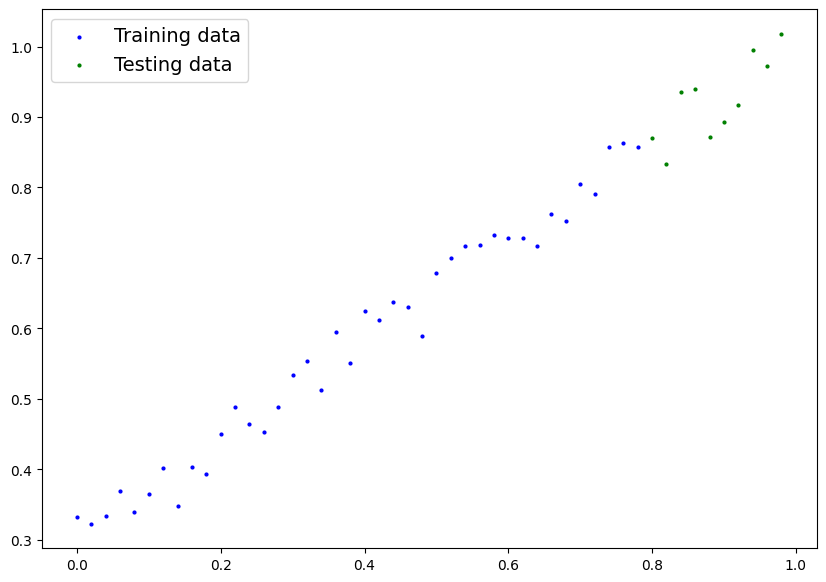

In [78]:
plot_predictions()

## Building PyTorch models

* `torch.nn` -> building blocks for computational graphs
* `torch.nn.Parameter` -> used to mark parameters that our model should learn, often a torch `Layer` will do this for us
* `torch.nn.Module` -> base class for all nn modules: when subclassing, must override `forward()`
* `torch.optim` -> optimizers implement gradient descent
* `def forward()` -> all nn.Module subclasses require you to override forward(), this methods define what happens in the forward / predictive computation

In [79]:
# Build model

# Almost anything in PT inherits from nn.Module -> basic model building block
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()

        # Parameter is a special type of Tensor that registers itself as a module param
        self.weights = nn.Parameter(torch.randn(1,
                                                requires_grad=True,
                                                dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1, 
                                              requires_grad=True,
                                              dtype=torch.float))

    # Forward method to define computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

# NN learns via:
# 1. Gradient Descent (require_grad=True)
# 2. Backpropagation        

In [80]:
torch.manual_seed(RANDOM_SEED)

model_0 = LinearRegressionModel()

list(model_0.named_parameters())

[('weights',
  Parameter containing:
  tensor([0.9047], device='mps:0', requires_grad=True)),
 ('bias',
  Parameter containing:
  tensor([-1.5057], device='mps:0', requires_grad=True))]

In [81]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.9047], device='mps:0')),
             ('bias', tensor([-1.5057], device='mps:0'))])

# Making Predictions

In [82]:
with torch.inference_mode():
    y_pred = model_0(X_test)

y_pred, y_test

(tensor([[-0.7819],
         [-0.7638],
         [-0.7457],
         [-0.7276],
         [-0.7095],
         [-0.6914],
         [-0.6734],
         [-0.6553],
         [-0.6372],
         [-0.6191]], device='mps:0'),
 tensor([[0.8703],
         [0.8330],
         [0.9351],
         [0.9398],
         [0.8723],
         [0.8928],
         [0.9165],
         [0.9947],
         [0.9723],
         [1.0181]], device='mps:0'))

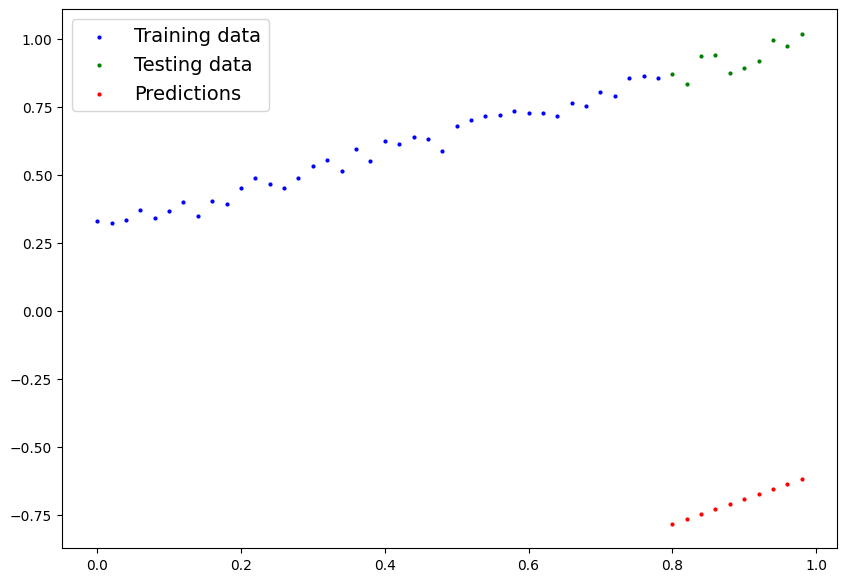

In [83]:
plot_predictions(predictions=y_pred)

## Model Training

To train a model we need:

1. __Loss__: A loss function / criterion / cost function -> measure how wrong predictions are wrt ideal output
2. __Optimizer__: Takes into account the model's loss and adjusts the model's parameters to improve it

Often losses and optimizers come in pairs.

Also, for PyTorch we need:
* Training Loop
* Testing Loop

In [84]:
# Setup a Loss Function

## Equivalent to torch.nn.L1Loss

mean_absolute_error_loss_fn = lambda y_pred, y_test: torch.mean(torch.abs(y_pred - y_test))
loss_fn = nn.L1Loss()

# Setup an Optimizer Function

## Basic Optimizers -> SGD -> Adam
## Params -> Parameters that must be updated in the training loop
## Learning Rate -> possibly the most important hyperparameter 

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)


with torch.inference_mode():
    dummy_pred, dummy_target = torch.rand(3, 4), torch.rand(3,4)
    loss_torch = loss_fn(dummy_pred, dummy_target)
    loss_custom = mean_absolute_error_loss_fn(dummy_pred, dummy_target)
    
loss_torch, loss_custom, loss_torch == loss_custom

(tensor(0.1828, device='mps:0'),
 tensor(0.1828, device='mps:0'),
 tensor(True, device='mps:0'))

### Building a training loop (and a test loop)

Components of a training loop:

0. Loop through the data
1. Set the model in training mode with `model.train()` -> PyTorch models are created in `model.eval()` mode: `model.train()` activates training features such as gradient tracking, batch normalization, dropout, autograd, enable forward and backward pass.
2. Forward pass (this involves data moving through our model's `forward()` functions) -> make predictions on data - also called forward propagation
3. Calculate the loss -> compare forward pass predictions to ground truth labels
4. Optimizer zero grad -> Zero the gradient in the optimizer from previous calculations, the computation graph of `model.parameters()` is preserved, you are just zeroing the computed gradients from `loss.backward()` -> this is needed because gradients are accumulated, not overwritten, in case we want to accumulate gradients from different batches
5. Loss backward -> move backwards through the network to calculate the gradient of each of the parameters of our model with respect to the loss (**backpropagation**)
6. Optimizer step -> use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)

In [85]:
# An epoch is one loop through the data...
# epochs is a hyperparameter because we set it ourselves

epochs = 1
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

### Training

# 0. Loop through data
for epoch in range(epochs):
    # 1. Set the model to training mode
    model_0.train()

    # 2. Forward pass
    y_pred = model_0.forward(X_train)

    # 3. Compute loss
    loss = loss_fn(y_pred, y_train)

    # 4. Optimizer zero grad
    optimizer.zero_grad()

    # 5. Perform backpropagation on the loss wrt the model's parameters
    loss.backward()

    # 6. Perform parameter optimization -> gradient descent
    optimizer.step()

/Users/Matteo.Fordiani/Library/Caches/pypoetry/virtualenvs/pytorch-basics-aT9may5l-py3.11/lib/python3.11/site-packages/torch/autograd/__init__.py:200: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
